PyTorch UNet implementation using IceNet library for data download and post-processing of sea ice forecasting.

This notebook has been designed to be independent of other notebooks.

### Highlights
The key features of this notebook are:
* [1. Download](#1.-Download) 
* [2. Data Processing](#2.-Data-Processing)
* [3. Train](#3.-Train)
* [4. Prediction](#4.-Prediction)
* [5. Outputs and Plotting](#5.-Outputs-and-Plotting)

Please note that this notebook relies on a pytorch data loader implementation which is only available from icenet v0.2.8+.

To install the necessary python packages, you can use the conda `icenet-notebooks/pytorch/environment.yml` environment file on a Linux system to be able to set-up the necessary pytorch + tensorflow + CUDA + other modules which could be a tricky mix to get working manually:

```bash
conda env create -f environment.yml
```

### Contributions
#### PyTorch implementation of UnetDiffusion
Maria Carolina Novitasari

#### PyTorch implementation of IceNet

Andrew McDonald ([icenet-gan](https://github.com/ampersandmcd/icenet-gan))

Bryn Noel Ubald (Refactor, updates for daily predictions and matching icenet library)

#### Notebook
Bryn Noel Ubald (author)

#### PyTorch Integration
Bryn Noel Ubald

Ryan Chan

### How to Download Daily Data for IceNet

#### DOWNLOAD SIC Data  

To download Sea Ice Concentration (SIC) data, modify the script below with the desired date range:

```python
sic = SICDownloader(
    dates=[
        pd.to_datetime(date).date()  # Dates to download SIC data for
        for date in pd.date_range("2020-01-01", "2020-12-31", freq="D")
    ],
    delete_tempfiles=True,           # Delete temporary downloaded files after use
    north=False,                     # Use mask for the Northern Hemisphere (set to True if needed)
    south=True,                      # Use mask for the Southern Hemisphere
    parallel_opens=True,             # Enable parallel processing with dask.delayed
)

sic.download()
```

#### Download ERA5 Data  

##### Setup ERA5 API

Use the following link to set up the ERA5 API: [https://cds.climate.copernicus.eu/how-to-api?](https://cds.climate.copernicus.eu/how-to-api?).

Run the following script with your desired dates:

#### ERA5 Downloader  

```python
import pandas as pd
from icenet.data.interfaces.cds import ERA5Downloader

era5 = ERA5Downloader(
    var_names=["tas", "zg", "uas", "vas"],      # Name of variables to download
    dates=[                                     # Dates to download the variable data for
        pd.to_datetime(date).date()
        for date in pd.date_range("2020-01-01", "2020-12-31", freq="D")
    ],
    path="./data",                              # Location to download data to (default is `./data`)
    delete_tempfiles=True,                      # Whether to delete temporary downloaded files
    levels=[None, [250, 500], None, None],      # The levels at which to obtain the variables for (e.g. for zg, it is the pressure levels)
    max_threads=4,                              # Maximum number of concurrent downloads
    north=False,                                # Boolean: Whether require data across northern hemisphere
    south=True,                                 # Boolean: Whether require data across southern hemisphere
    use_toolbox=False)                          # Experimental, alternative download method

era5.download()                                 # Start downloading
```

The prototype data currently in use (South Pole, 2020) can be downloaded from **Baskerville** at the following path: `/vjgo8416-ice-frcst/shared/prototype_data/`

In [1]:
import os
import numpy as np
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Tuple
from torchmetrics import Metric
import lightning.pytorch as pl
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS
from torchmetrics import MetricCollection
from torch_ema import ExponentialMovingAverage
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

# We also set the logging level so that we get some feedback from the API
import logging
logging.basicConfig(level=logging.INFO)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_float32_matmul_precision('medium')

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print(os.getcwd())

from models import GaussianDiffusion, UNetDiffusion, LitDiffusion
from trainers import DiffusionTrainer
from omegaconf import OmegaConf

cfg = OmegaConf.load("../configs/ddpm_config.yaml")

/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks


2025-09-09 20:11:01.597058: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-09 20:11:03.391004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-09 20:11:03.391112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-09 20:11:03.540655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-09 20:11:03.750435: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

seed = cfg.train.seed

torch.manual_seed(seed)           # PyTorch CPU
torch.cuda.manual_seed(seed)      # PyTorch single GPU
torch.cuda.manual_seed_all(seed)  # PyTorch multi-GPU
np.random.seed(seed)              # NumPy
random.seed(seed)                 # Python built-in random

# # PyTorch deterministic settings
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

In [4]:
from datetime import datetime
import sys

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
sys.stdout = open(f'training_logs/training_log_{timestamp}_refactor.txt', 'w')

## 1. Download

In [5]:
import numpy
from icenet.data.sic.mask import Masks
from icenet.data.interfaces.cds import ERA5Downloader
from icenet.data.sic.osisaf import SICDownloader

In [6]:
# Unset SLURM_NTASKS if it's causing issues
if "SLURM_NTASKS" in os.environ:
    del os.environ["SLURM_NTASKS"]

# Optionally, set SLURM_NTASKS_PER_NODE if needed
os.environ["SLURM_NTASKS_PER_NODE"] = "1"  # or whatever value is appropriate

### Mask data

Create masks for masking data.

In [7]:
masks = Masks(north=False, south=True)
masks.generate(save_polarhole_masks=False)

INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_01.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_02.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_03.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_04.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_05.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_06.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_07.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_08.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_09.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_10.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_11.npy, already exists
INFO:root:Skipping ./

### Climate and Sea Ice data

Download climate variables from ERA5 and sea ice concentration from OSI-SAF.

In [8]:
era5 = ERA5Downloader(
    var_names=["tas", "zg", "uas", "vas"],
    levels=[None, [250, 500], None, None],
    dates=[pd.to_datetime(date).date() for date in
           # pd.date_range("2020-01-01", "2020-04-30", freq="D")],
           pd.date_range("2018-01-01", "2020-12-31", freq="D")],
    delete_tempfiles=False,
    max_threads=64,
    north=False,
    south=True,
    # NOTE: there appears to be a bug with the toolbox API at present (icenet#54)
    use_toolbox=False
)

# era5.download()

2025-09-09 20:11:57,626 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:root:Upping connection limit for max_threads > 10


In [9]:
sic = SICDownloader(
    dates=[pd.to_datetime(date).date() for date in
           # pd.date_range("2020-01-01", "2020-04-30", freq="D")],
           pd.date_range("2018-01-01", "2020-12-31", freq="D")],
    delete_tempfiles=False,
    north=False,
    south=True,
    parallel_opens=False,
)

# sic.download()

Re-grid ERA5 reanalysis data, and rotate wind vector data from ERA5 to align with EASE2 projection.

In [10]:
era5.regrid()
era5.rotate_wind_data()

INFO:root:No regrid batches to processing, moving on...
INFO:root:Rotating wind data prior to merging
INFO:root:Rotating wind data in ./data/era5/south/uas ./data/era5/south/vas
INFO:root:0 files for uas
INFO:root:0 files for vas
INFO:root:Rotating wind data in ./data/era5/south/uas ./data/era5/south/vas
INFO:root:0 files for uas
INFO:root:0 files for vas


## 2. Data Processing

Process downloaded datasets.

To make life easier, setting up train, val, test dates.

In [11]:
processing_dates = dict(
    train=[pd.to_datetime(el) for el in pd.date_range("2020-01-01", "2020-03-31")],
    val=[pd.to_datetime(el) for el in pd.date_range("2020-04-03", "2020-04-23")],
    test=[pd.to_datetime(el) for el in pd.date_range("2020-04-01", "2020-04-02")],
)
processed_name = "notebook_api_pytorch_data"

Next, we create the data producer and configure them for the dataset we want to create.

In [12]:
from icenet.data.processors.era5 import IceNetERA5PreProcessor
from icenet.data.processors.meta import IceNetMetaPreProcessor
from icenet.data.processors.osi import IceNetOSIPreProcessor

pp = IceNetERA5PreProcessor(
    ["uas", "vas"],
    ["tas", "zg500", "zg250"],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)

osi = IceNetOSIPreProcessor(
    ["siconca"],
    [],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)

meta = IceNetMetaPreProcessor(
    processed_name,
    north=False,
    south=True
)

Next, we initialise the data processors using `init_source_data` which scans the data source directories to understand what data is available for processing based on the parameters. Since we named the processed data `"notebook_api_data"` above, it will create a data loader config file, `loader.notebook_api_data.json`, in the current directory.

In [13]:
# Causes hanging on training, when generating sample.
pp.init_source_data(
    lag_days=1,
)
pp.process()

osi.init_source_data(
    lag_days=1,
)
osi.process()

meta.process()

INFO:root:Processing 91 dates for train category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:No data found for 2019-12-31, outside data boundary perhaps?
INFO:root:Processing 21 dates for val category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Processing 2 dates for test category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Got 1 files for tas
INFO:root:Got 1 files for uas
INFO:root:Got 1 files for vas
INFO:root:Got 1 files for zg250
INFO:root:Got 1 files for zg500
INFO:root:Opening files for uas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Normalising uas
INFO:root:Opening files for vas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Normalising vas
INFO:root:Opening files for tas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Reusing climatology ./processed/notebook_api_

At this point the preprocessed data is ready to convert or create a configuration for the network dataset.

### Dataset creation

As with the `icenet_dataset_create` command we can create a dataset configuration for training the network. As before this can include cached data for the network in the format of a TFRecordDataset compatible set of tfrecords. To achieve this we create the `IceNetDataLoader`, which can both generate `IceNetDataSet` configurations (which easily provide the necessary functionality for training and prediction) as well as individual data samples for direct usage.

In [14]:
from icenet.data.loaders import IceNetDataLoaderFactory

implementation = "dask"
loader_config = "loader.notebook_api_pytorch_data.json"
dataset_name = "notebook_api_pytorch_data"
lag = 1

dl = IceNetDataLoaderFactory().create_data_loader(
    implementation,
    loader_config,
    dataset_name,
    lag,
    n_forecast_days=7,
    north=False,
    south=True,
    output_batch_size=1,
    generate_workers=4)

INFO:root:Loading configuration loader.notebook_api_pytorch_data.json


At this point we can either use `generate` or `write_dataset_config_only` to produce a ready-to-go `IceNetDataSet` configuration. Both of these will generate a dataset config, `dataset_config.notebook_api_pytorch_data.json` (recall we set the dataset name as `notebook_api_pytorch_data` above).

In this case, for pytorch, will read data in directly, rather than using cached tfrecords inputs.

In [15]:
dl.write_dataset_config_only()

INFO:root:Writing dataset configuration without data generation
INFO:root:91 train dates in total, NOT generating cache data.
INFO:root:21 val dates in total, NOT generating cache data.
INFO:root:2 test dates in total, NOT generating cache data.
INFO:root:Writing configuration to ./dataset_config.notebook_api_pytorch_data.json


We can now create the IceNetDataSet object:

In [16]:
from icenet.data.dataset import IceNetDataSetPyTorch
dataset_config = f"dataset_config.{dataset_name}.json"

## 3. Train

We implement a custom PyTorch class for training.

## IceNet2 U-Net Diffusion model

Maria's work (PyTorch Diffusion using U-Net)

In [17]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode):
        super().__init__()
        self.interp = F.interpolate
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

Define custom metrics for use in validation and monitoring

Define custom loss functions

A _LightningModule_ wrapper for UNetDiffusion model.

Function for training UNetDiffusion model using PyTorch Lightning.

Conduct actual training run.

In [ ]:
diffusion_trainer = DiffusionTrainer(cfg)
model, trainer_obj, checkpoint_callback = diffusion_trainer.train()

[rank: 0] Seed set to 45
INFO:trainers.diffusion_trainer:Setting up datasets and dataloaders...
INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/loader.notebook_api_pytorch_data.json
INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/loader.notebook_api_pytorch_data.json
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env3/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/my

## 4. Prediction

Predicts using the best checkpoint from the training.

In [30]:
checkpoint_callback.best_k_models

{'/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/training/local/diffusion_run_20250909_201214/checkpoints/diffusion-epoch=86-val_accuracy=95.7440.ckpt': tensor(95.7440),
 '/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/training/local/diffusion_run_20250909_201214/checkpoints/diffusion-epoch=88-val_accuracy=95.7346.ckpt': tensor(95.7346),
 '/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/training/local/diffusion_run_20250909_201214/checkpoints/diffusion-epoch=89-val_accuracy=95.7460.ckpt': tensor(95.7460)}

In [31]:
best_checkpoint = checkpoint_callback.best_model_path
best_checkpoint

'/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/training/local/diffusion_run_20250909_201214/checkpoints/diffusion-epoch=89-val_accuracy=95.7460.ckpt'

In [32]:
# Load the best result from the checkpoint
best_model = LitDiffusion.load_from_checkpoint(best_checkpoint)

# disable randomness, dropout, etc...
best_model.eval()

LitDiffusion(
  (model): UNetDiffusion(
    (time_embed): TimeEmbed(
      (model): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): SiLU(inplace=True)
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
    )
    (conv1): CommonConvBlock(
      (block1): ConvNormAct(
        (block): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): GroupNorm(8, 32, eps=1e-05, affine=True)
          (2): SiLU(inplace=True)
        )
      )
      (block2): ConvNormAct(
        (block): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): GroupNorm(8, 32, eps=1e-05, affine=True)
          (2): SiLU(inplace=True)
        )
      )
    )
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): CommonConvBlock(
      (block1): ConvNormAct(
        (block): Sequential(
          (0): Conv

In [33]:
test_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=cfg.train.dataloader.batch_size, num_workers=cfg.train.dataloader.n_workers,
                             persistent_workers=cfg.train.dataloader.persistent_workers, shuffle=cfg.train.dataloader.shuffle)

# automatically load the best weights (if best_model isn't added)
diffusion_trainer.trainer.test(dataloaders=test_dataloader)

INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/loader.notebook_api_pytorch_data.json
Restoring states from the checkpoint path at /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/training/local/diffusion_run_20250909_201214/checkpoints/diffusion-epoch=89-val_accuracy=95.7460.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/training/local/diffusion_run_20250909_201214/checkpoints/diffusion-epoch=89-val_accuracy=95.7460.ckpt
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env3/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" star

[{'test_loss': 27.714136123657227,
  'test_accuracy': 96.2362289428711,
  'test_accuracy_0': 97.95313262939453,
  'test_accuracy_1': 97.09957885742188,
  'test_accuracy_2': 96.47531127929688,
  'test_accuracy_3': 96.02677917480469,
  'test_accuracy_4': 95.87113189697266,
  'test_accuracy_5': 95.4811782836914,
  'test_accuracy_6': 94.74644470214844,
  'test_sieerror': -923125.0,
  'test_sieerror_0': 437500.0,
  'test_sieerror_1': 227500.0,
  'test_sieerror_2': -170000.0,
  'test_sieerror_3': -281875.0,
  'test_sieerror_4': -220625.0,
  'test_sieerror_5': -230625.0,
  'test_sieerror_6': -685000.0}]

In [34]:
logging.info("Generating predictions")

predictions = diffusion_trainer.trainer.predict(best_model, dataloaders=test_dataloader)

INFO:root:Generating predictions
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env3/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env3/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


In [35]:
predictions = [p.unsqueeze(-2) for p in predictions]

for worker, prediction in enumerate(predictions):
    print(f"Worker: {worker} | Prediction: {prediction.shape}")

## 5. Outputs and Plotting

Create prediction output directory

In [36]:
# dataset = "pytorch_notebook"
network_name = "api_pytorch_dataset"
output_name = "example_pytorch_forecast_test"
output_folder = os.path.join(".", "results", "predict", output_name,
                                "{}.{}".format(network_name, cfg.train.seed))
os.makedirs(output_folder, exist_ok=output_folder)

Convert and output predictions to numpy files

In [37]:
idx = 0
for workers, prediction in enumerate(predictions):
    for batch in range(prediction.shape[0]):
        date = pd.Timestamp(test_dataset.dates[idx].replace('_', '-'))
        output_path = os.path.join(output_folder, date.strftime("%Y_%m_%d.npy"))
        forecast = prediction[batch, :, :, :, :].movedim(-2, 0)
        forecast_np = forecast.detach().cpu().numpy()
        np.save(output_path, forecast_np)
        idx += 1

Create a csv file with all the test dates we have predicted for, and to use in generating the final netCDF output using `icenet_output`.

In [38]:
!printf "2020-04-01\n2020-04-02" | tee testdates.csv

In [39]:
import sys
!{sys.executable.replace('python', 'icenet_output')}  -m -o results/predict example_pytorch_forecast_test notebook_api_pytorch_data testdates.csv

INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1096872/events.out.tfevents.1757445135.bask-pg0308u15a.1995593.0 to lightning_logs/version_1096872/events.out.tfevents.1757459297.bask-pg0308u15a.1995593.1
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1096872/events.out.tfevents.1757459297.bask-pg0308u15a.1995593.1 to lightning_logs/version_1096872/events.out.tfevents.1757459317.bask-pg0308u15a.1995593.2
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1096872/events.out.tfevents.1757459317.bask-pg0308u15a.1995593.2 to lightning_logs/version_1096872/events.out.tfevents.1757494527.bask-pg0308u15a.1995593.3
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1096872/events.out.tfevents.1757494527.bask-pg0308u15a.1995593.3 to lightning_logs/version_1096872/events.out.tfevents.1757494547.bask-pg0308u15a.1995593.4
INFO:tensorboard:No path found after lightning_logs/version_1096872/events.out.tfeve

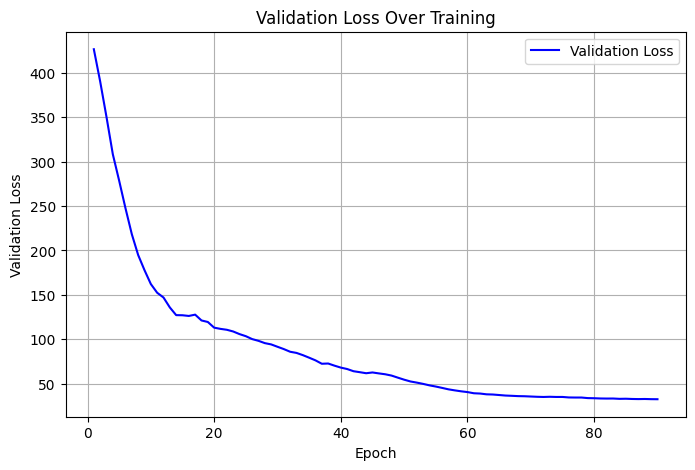

In [41]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Change this to the actual version dir
log_dir = "lightning_logs/version_1096872" 

# Load the logs
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# List all scalar tags to find the correct name
print("Available tags:", event_acc.Tags()['scalars'])

# Get the scalar events for val_loss
val_loss_events = event_acc.Scalars('val_loss')

steps = list(range(1, len(val_loss_events) + 1))
values = [e.value for e in val_loss_events]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label='Validation Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Over Training")
plt.legend()
plt.grid(True)
plt.show()

INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1096872/events.out.tfevents.1757445135.bask-pg0308u15a.1995593.0 to lightning_logs/version_1096872/events.out.tfevents.1757459297.bask-pg0308u15a.1995593.1
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1096872/events.out.tfevents.1757459297.bask-pg0308u15a.1995593.1 to lightning_logs/version_1096872/events.out.tfevents.1757459317.bask-pg0308u15a.1995593.2
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1096872/events.out.tfevents.1757459317.bask-pg0308u15a.1995593.2 to lightning_logs/version_1096872/events.out.tfevents.1757494527.bask-pg0308u15a.1995593.3
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1096872/events.out.tfevents.1757494527.bask-pg0308u15a.1995593.3 to lightning_logs/version_1096872/events.out.tfevents.1757494547.bask-pg0308u15a.1995593.4
INFO:tensorboard:No path found after lightning_logs/version_1096872/events.out.tfeve

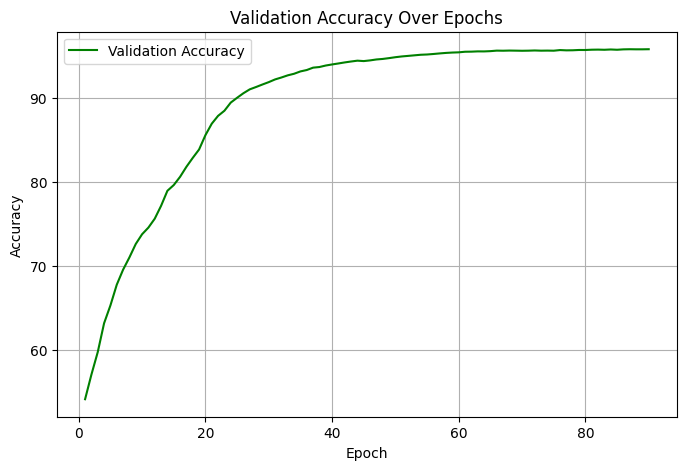

In [42]:
# Update with your actual path
log_dir = "lightning_logs/version_1096872" 

event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# List all available scalar tags
print("Available scalar tags:")
print(event_acc.Tags()['scalars'])  

# Get accuracy for all lead times (overall accuracy)
accuracy_events = event_acc.Scalars('val_accuracy')

steps = list(range(1, len(accuracy_events) + 1))
values = [e.value for e in accuracy_events]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label='Validation Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Plotting the forecast

In [43]:
import xarray as xr
import datetime as dt
from IPython.display import HTML

In [44]:
from icenet.plotting.video import xarray_to_video as xvid
from icenet.data.sic.mask import Masks

ds = xr.open_dataset("results/predict/example_pytorch_forecast_test.nc")
land_mask = Masks(south=True, north=False).get_land_mask()
ds.info()

Animate result

In [45]:
forecast_date = ds.time.values[0]
fc = ds.sic_mean.isel(time=0).drop_vars("time").rename(dict(leadtime="time"))
fc['time'] = [pd.to_datetime(forecast_date) \
              + dt.timedelta(days=int(e)) for e in fc.time.values]

anim = xvid(fc, 15, figsize=(4,4), mask=land_mask)
HTML(anim.to_jshtml())

INFO:root:Inspecting data
INFO:root:Initialising plot
INFO:root:Animating
INFO:root:Not saving plot, will return animation
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


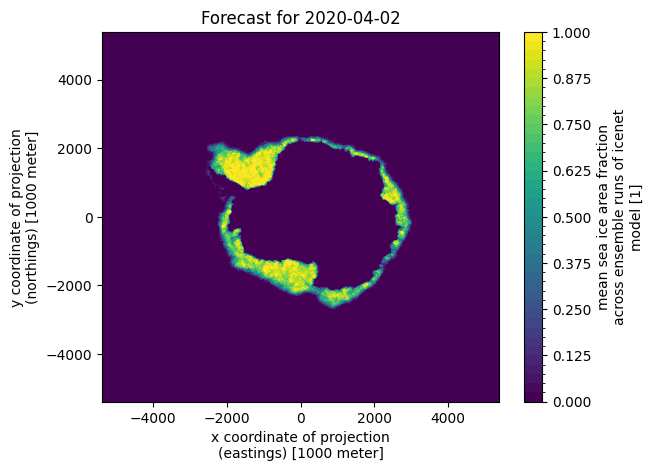

In [46]:
import xarray as xr
import matplotlib.pyplot as plt

# Select one forecast frame (e.g., time index 0)
fc_flat = fc.isel(time=0)
timestamp = pd.to_datetime(fc.time.values[0])

# Plot it flat with contourf
fc_flat.plot.contourf(levels=50, cmap='viridis')  # or any colormap you like
plt.title("Forecast SIC (flat projection)")
plt.title(f"Forecast for {timestamp.strftime('%Y-%m-%d')}")
plt.show()

Check min/max of predicted SIC fraction

In [47]:
print( forecast_np[:, :, :, 0].shape )
fmin, fmax = np.min(forecast_np[:, :, :, 0]), np.max(forecast_np[:, :, :, 0])
print( f"First forecast day min: {fmin:.4f}, max: {fmax:.4f}" )

#### Load original input dataset

This is the original input dataset (pre-normalisation) for comparison.

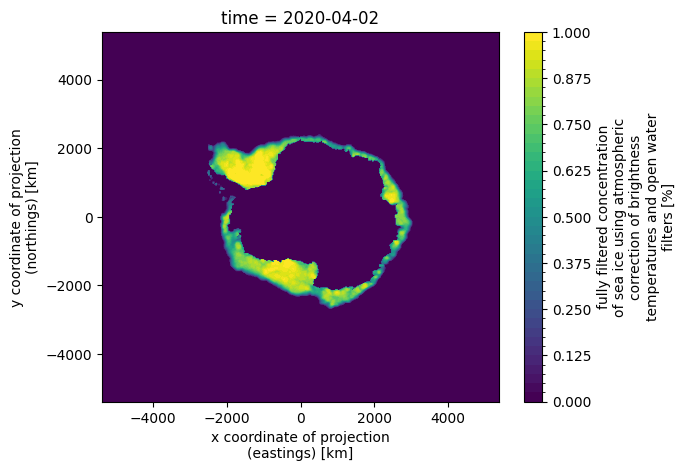

In [48]:
# Load original input dataset (domain not normalised)
xr.plot.contourf(xr.open_dataset("data/osisaf/south/siconca/2020.nc").isel(time=92).ice_conc, levels=50)

## Version
- IceNet Codebase: v0.2.8